# Kidney Exchange QAOA Example

Author: Bill Wisotsky  

---

<u>What is the Problem?</u>  
Currently there are more than 100,000 patients on the waitling list in the United States for a kidney transplant from a deceased donor. This is addressed by the a program called the Kidney Exchange Program.  This program won the Nobel Prize in Economics for Alvin E. Roth and Lloyd S. Shapley's contributions to the <i>theory of stable matchings and the design of markets on 2012.</i>
In summary, in a donor pair there is a recipient who needs a kidney transplant and a donor who is willing to give their kidney to the recipient. About $\frac{1}{3}$ of those pairs are not compatible for a direct exchange. This is tackled by considering two incompatible pairs together: donor 1 may be compatible with recpient 2 and donor 2 may be compatible with recpient 1. In this example a two-way swap becomes feasible. This is the core of the kideny exchange program.  

This is consdered an NP-Hard combinatorial optimization problem that becomes exponetially more difficult as the size of the pool increases. The longest chain in history involved 35 tranplants in the United States in 2015.

In [2]:
import warnings
from itertools import product
from typing import List, Tuple, cast  # noqa

import networkx as nx  # noqa
import numpy as np

from classiq import *

warnings.filterwarnings("ignore")

## Create the pyomo model for a simple kidney exhange problem 

In this very simple example, patients and donors represent sets of patients that receive a kidney from a donor. Compatibility is a dictionary mapping of patient-donor paris to their compatibilty scores. Binary decision variables are defined for each patient-donor pair x[donor,patient]. The objective is to maximize the total compatibility score. $ Maximize \sum_{d,p\in A}^{} \sum_{m\in M}c_{dp}x_{dpm}$ where d=donors, p=patients and c=compatability score. The contraints are added to ensure that each donor donates only once $\sum_{d,p\in A}^{}x_{dpm} = y_{dm}$ and each patient receives once $\sum_{d,p\in A}^{}x_{dpm} = y_{pm}$. We are creating a PYOMO model that gets fed into Classiq, as illustrated in Classiq documentation. We also solve initially with a classical solver to get inital results which can be compared to the QAOA results in the end.

In [3]:
from pyomo.environ import *

# Sample data: patient-donor pairs and compatibility scores
donors = ["donor1", "donor2", "donor3"]
patients = ["patient1", "patient2", "patient3"]
N = len(patients)
M = len(donors)
# Parameters
compatibility_scores = {
    ("donor1", "patient1"): 0.9,
    ("donor1", "patient2"): 0.7,
    ("donor1", "patient3"): 0.6,
    ("donor2", "patient1"): 0.8,
    ("donor2", "patient2"): 0.75,
    ("donor2", "patient3"): 0.65,
    ("donor3", "patient1"): 0.85,
    ("donor3", "patient2"): 0.8,
    ("donor3", "patient3"): 0.7,
}

# Create Pyomo model
model = ConcreteModel()

# Variables
model.x = Var(donors, patients, within=Binary)

# Objective
model.obj = Objective(
    expr=sum(
        compatibility_scores[donor, patient] * model.x[donor, patient]
        for donor in donors
        for patient in patients
    ),
    sense=maximize,
)

# Constraints
model.donor_constraint = ConstraintList()
for donor in donors:
    model.donor_constraint.add(
        sum(model.x[donor, patient] for patient in patients) <= 1
    )

model.patient_constraint = ConstraintList()
for patient in patients:
    model.patient_constraint.add(sum(model.x[donor, patient] for donor in donors) <= 1)

# Install "glpk" and unommente for runing this part
# Solve
# solver = SolverFactory("glpk")
# solver.solve(model)

# Output
print("\033[1m\033[4mOptimal solution:\033[0m")
for donor in donors:
    for patient in patients:
        if model.x[donor, patient].value == 1:
            print(f"{donor} donates kidney to {patient}")

print("\n\033[1m\033[4mModel Details\033[0m")
model.pprint()

Optimal solution:

Model Details
5 Set Declarations
    donor_constraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    patient_constraint_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :    9 : {('donor1', 'patient1'), ('donor1', 'patient2'), ('donor1', 'patient3'), ('donor2', 'patient1'), ('donor2', 'patient2'), ('donor2', 'patient3'), ('donor3', 'patient1'), ('donor3', 'patient2'), ('donor3', 'patient3')}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'donor1', 'donor2', 'donor3'}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dime

## Start Generatng the QAOA Process
  
### Create the inital parameters for the quantum circuit. These can me modified as needed.
1. Defining the number of layers (num_layers) of the QAOA Ansatz.  
2. Define the penalty_energy for invalid solutions, which influences the convergence rate. Smaller positive values are preferred, but shoudl be tweaked.  


In [4]:
from classiq import (
    Preferences,
    construct_combinatorial_optimization_model,
    set_preferences,
)
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5, penalty_energy=2)

### Create the classical optimizer part of the QAOA. These parameters can be modified.
1. opt_type is the classical optimizer type. Choices include, COBYLA, SPSA, ADAM, L_BFGS_B, and NELDER_MEAD
2. The max_iterations is the maximum number of optimzer iterations and is set to 100.  
3. The alpha_cvar is a parameter that describes the quantile considered in the CVAR expectation value. See https://arxiv.org/abs/1907.04769 for more information.

In [5]:
optimizer_config = OptimizerConfig(
    # opt_type='COBYLA',
    max_iteration=200,
    alpha_cvar=1,
)

### Combine everthing together to form the entire QAOA model as a QMOD.
1. PYOMO Model  
2. QAOA quantum circuit  
3. Clasical optimizer  

In [6]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

# defining cosntraint such as computer and parameters for a quicker and more optimized circuit.
preferences = Preferences(transpilation_option="none", timeout_seconds=300)

qmod = set_preferences(qmod, preferences)

1. Wite out the QMOD and preferences to a JSON file  
2. Synthesize the model in Classiq interface  
 

In [7]:
write_qmod(qmod, "kidney_exchange_problem")  # optional

1. Sythesize the quantum model
2. Show the quantm model in the Classiq platform

In [8]:
qmod = set_constraints(qmod, Constraints(optimization_parameter="width"))
qprog = synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2zBS1L0WJarbWUZnsUhf4SSOYQE


In [9]:
qprog.

AttributeError: 'QuantumProgram' object has no attribute 'depth'

Execute the quantum model and store the result.

In [32]:
from classiq import execute

res = execute(qprog).result()

View the convergence graph  
<i>Important to remember that this is a maximization problem when looking at the graph</i>

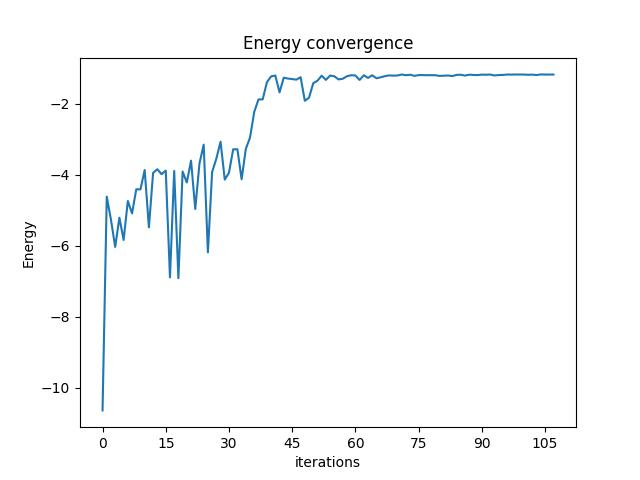

In [33]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

## Retrieve and Display the Solutions
- Print them out
- Graph using a histogram
- Show Donor - Recipients in Network Graph

### Print out the top 10 solutions with the highest cost or objective

In [34]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)

optimization_result = pd.DataFrame.from_records(solution)

print("\n\033[1m\033[4mTop 10 Solutions\033[0m")
optimization_result.sort_values(by="cost", ascending=False).head(10)


Top 10 Solutions


,probability,cost,solution,count
48,0.002930,2.35,"[1, 0, 0, 0, 0, 1, 0, 1, 0]",6
53,0.002930,2.35,"[1, 0, 0, 0, 1, 0, 0, 0, 1]",6
32,0.005371,2.20,"[0, 0, 1, 1, 0, 0, 0, 1, 0]",11
108,0.001465,2.20,"[0, 1, 0, 1, 0, 0, 0, 0, 1]",3
54,0.002930,2.20,"[0, 1, 0, 0, 0, 1, 1, 0, 0]",6
34,0.004883,2.20,"[0, 0, 1, 0, 1, 0, 1, 0, 0]",10
16,0.013672,1.70,"[1, 0, 0, 0, 0, 0, 0, 1, 0]",28
7,0.019531,1.65,"[1, 0, 0, 0, 1, 0, 0, 0, 0]",40
13,0.015625,1.60,"[0, 0, 0, 1, 0, 0, 0, 1, 0]",32
12,0.015625,1.60,"[1, 0, 0, 0, 0, 0, 0, 0, 1]",32


### Histogram of Cost and Weighted by Probability

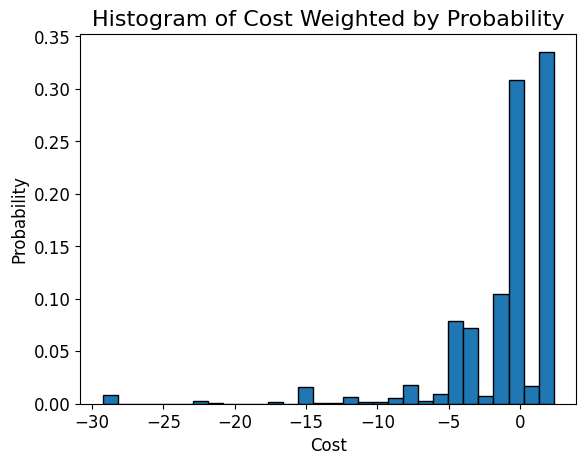

In [35]:
import matplotlib.pyplot as plt

optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=12)
plt.xlabel("Cost", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.title("Histogram of Cost Weighted by Probability", fontsize=16)
plt.show()

### Create a Network Graph for the Best Solution Found
<b>$\star$ Very important to remember that this is a mximization problem and the classical solver of the QAOA process returns all possible results. We need to filter out the solution with the highest cost which would represent the the highest compatability score. </b>

** QAOA SOLUTION **
Highest Compatibility Score =  2.3499999999999996
        patient1  patient2  patient3
donor1         1         0         0
donor2         0         0         1
donor3         0         1         0


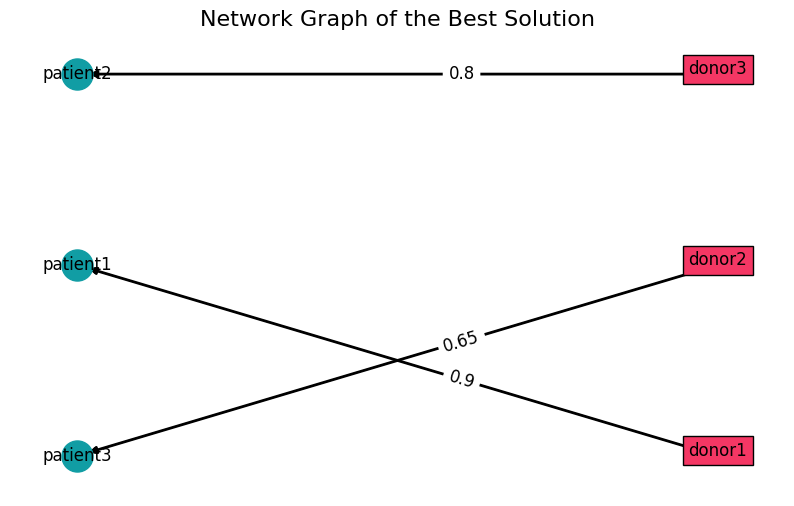

In [36]:
# This function plots the solution in a table and a graph


def plotting_sol(x_sol, cost):
    x_sol_to_mat = np.reshape(np.array(x_sol), [N, M])  # vector to matrix
    print("\033[1m\033[4m** QAOA SOLUTION **\033[0m")
    print("\033[4mHighest Compatibility Score\033[0m = ", cost)

    # plotting in a table
    df = pd.DataFrame(x_sol_to_mat)
    df.columns = patients
    df.index = donors
    print(df)

    # plotting in a graph
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(donors + patients)
    for n, m in product(range(N), range(M)):
        if x_sol_to_mat[n, m] > 0:
            graph_sol.add_edges_from(
                [(donors[m], patients[n])],
                weight=compatibility_scores[(donors[m], patients[n])],
            )

    plt.figure(figsize=(10, 6))
    left = nx.bipartite.sets(graph_sol, top_nodes=patients)[0]
    pos = nx.bipartite_layout(graph_sol, left)

    nx.draw_networkx(
        graph_sol, pos=pos, nodelist=patients, font_size=22, font_color="None"
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=patients, node_color="#119DA4", node_size=500
    )
    for d in donors:
        x, y = pos[d]
        plt.text(
            x,
            y,
            s=d,
            bbox=dict(facecolor="#F43764", alpha=1),
            horizontalalignment="center",
            fontsize=12,
        )

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(
        graph_sol, pos, edge_labels=labels, font_size=12, label_pos=0.6
    )
    nx.draw_networkx_labels(
        graph_sol,
        pos,
        labels={co: co for co in patients},
        font_size=12,
        # font_color="#F4F9E9",
    )
    plt.title("Network Graph of the Best Solution", fontsize=16)
    plt.axis("off")
    plt.show()


# best_solution = optimization_result.loc[optimization_result.probability.idxmax()]
# plotting_sol(best_solution.solution, best_solution.probability)

best_solution = optimization_result.loc[optimization_result.cost.idxmax()]
plotting_sol(best_solution.solution, best_solution.cost)